# **MNIST classification with TensorFlow model**

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os, sys

workdir_path = '/content/drive/My Drive/ICA/01_MNIST_tensorflow'
os.chdir(workdir_path)
sys.path.append(workdir_path)

Predictions 

In [0]:
import tensorflow as tf
tf.reset_default_graph()
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt     # only to show the images at end
from numpy.random import randint    # only to generate a random nuymber ar end
from numpy import argmax

set the basic configurations, load the MNIST database and convert it to the necessary format

In [34]:
# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 128
display_step = 100

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input], name='x_1')
Y = tf.placeholder(tf.float32, [None, num_classes], name='y_1')
keep_prob = tf.placeholder(tf.float32, name='keep_prob') # dropout (keep probability)

# load the data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [0]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [37]:
#to show nodes
[n.name for n in tf.get_default_graph().as_graph_def().node]

['x_1',
 'y_1',
 'keep_prob',
 'random_normal/shape',
 'random_normal/mean',
 'random_normal/stddev',
 'random_normal/RandomStandardNormal',
 'random_normal/mul',
 'random_normal',
 'Variable',
 'Variable/Assign',
 'Variable/read',
 'random_normal_1/shape',
 'random_normal_1/mean',
 'random_normal_1/stddev',
 'random_normal_1/RandomStandardNormal',
 'random_normal_1/mul',
 'random_normal_1',
 'Variable_1',
 'Variable_1/Assign',
 'Variable_1/read',
 'random_normal_2/shape',
 'random_normal_2/mean',
 'random_normal_2/stddev',
 'random_normal_2/RandomStandardNormal',
 'random_normal_2/mul',
 'random_normal_2',
 'Variable_2',
 'Variable_2/Assign',
 'Variable_2/read',
 'random_normal_3/shape',
 'random_normal_3/mean',
 'random_normal_3/stddev',
 'random_normal_3/RandomStandardNormal',
 'random_normal_3/mul',
 'random_normal_3',
 'Variable_3',
 'Variable_3/Assign',
 'Variable_3/read',
 'random_normal_4/shape',
 'random_normal_4/mean',
 'random_normal_4/stddev',
 'random_normal_4/RandomStanda

In [38]:
# Start training
sess = tf.Session()
sess.run(init)
for step in range(1, num_steps+1):
  batch_x, batch_y = mnist.train.next_batch(batch_size)
  # Run optimization op (backprop)
  sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
  if step % display_step == 0 or step == 1:
    # Calculate batch loss and accuracy
    loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                        Y: batch_y,
                                                        keep_prob: 1.0})
    print("Step " + str(step) + ", Minibatch Loss= " + \
      "{:.4f}".format(loss) + ", Training Accuracy= " + \
      "{:.3f}".format(acc))

print("Optimization Finished!")

# Calculate accuracy for 256 MNIST test images
print("Testing Accuracy:", sess.run(accuracy, feed_dict={X: mnist.test.images[:256], Y: mnist.test.labels[:256], keep_prob: 1.0}))

Step 1, Minibatch Loss= 47806.1016, Training Accuracy= 0.125
Step 100, Minibatch Loss= 1645.4486, Training Accuracy= 0.906
Step 200, Minibatch Loss= 901.8420, Training Accuracy= 0.914
Step 300, Minibatch Loss= 371.5577, Training Accuracy= 0.969
Step 400, Minibatch Loss= 1127.8197, Training Accuracy= 0.914
Step 500, Minibatch Loss= 584.1743, Training Accuracy= 0.945
Optimization Finished!
Testing Accuracy: 0.9765625


Predictions 

9350
prediction:  4
real value:  4


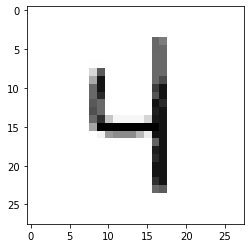

In [39]:
i=randint(1, mnist.test.images.shape[0])
print(i)
plt.imshow(mnist.test.images[i].reshape((28,28)), cmap='Greys')    #  cmap='Greys' to show as greyscale
print("prediction: ", argmax(sess.run('Softmax:0', feed_dict={'x_1:0': mnist.test.images[i:i+1], 'keep_prob:0': 1.0})))
print("real value: ", argmax(mnist.test.labels[i:i+1]))

In [40]:
sess.run('Softmax:0', feed_dict={'x_1:0': mnist.test.images[0:4], 'keep_prob:0': 1.0})

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Save model

In [41]:
saver = tf.train.Saver()
# Save checkpoint
saver.save(sess,'./tensorflowcheckpoint.ckpt')
# Save GraphDef
tf.train.write_graph(sess.graph_def,'.','tensorflowModel.pb')

'./tensorflowModel.pb'

Freezing

In [0]:
import tensorflow as tf
tf.reset_default_graph()
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

In [43]:
freeze_graph.freeze_graph('tensorflowModel.pb', "", False, 
                          './tensorflowcheckpoint.ckpt', "Softmax",
                           "", "",
                           'tensorflowModel_graph_frozen.pb', True, ""  
                         )

INFO:tensorflow:Restoring parameters from ./tensorflowcheckpoint.ckpt
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


Optimize

In [44]:
! python -m tensorflow.python.tools.optimize_for_inference \
--input tensorflowModel_graph_frozen.pb \
--output tensorflowModel_graph_optimized.pb \
--input_names=x_1,keep_prob \
--output_names=Softmax \
--placeholder_type_enum=1

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
W1205 16:07:06.176154 140157783787392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/tools/strip_unused_lib.py:88: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
W1205 16:07:06.177587 140157783787392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/tools/optimize_for_inference_lib.py:113: remove_training_nodes (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


In [45]:
! nvidia-smi


Thu Dec  5 16:07:07 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |   1061MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  